In [1]:
import tensorflow as tf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow_hub as hub
import seaborn as sns

import pathlib
import os
import shutil
import time
import cv2
import pathlib

from PIL import Image
from tensorflow import keras

In [2]:
print(tf.__version__)

2.11.0


In [3]:
path = r'C:/Users/SHOCKER/Downloads/Compressed/images_2/images/'
train = pd.read_csv(r'C:\Users\SHOCKER\Downloads\train_labels.csv')

In [4]:
images = list(os.listdir(path))

### After some analysis, some of the images seem to have a channel of 4. So I removed them from the dataset

In [5]:
channel = []
for i in os.listdir(path):
    img = tf.io.read_file(f'{path}/{i}')
    img = tf.io.decode_jpeg(img)
    channel.append((f'{path}/{i}', img.shape[2]))

In [6]:
for i, l in channel:
    if l == 4:
        print(i, l)

C:/Users/SHOCKER/Downloads/Compressed/images_2/images//fhikknnhdjhhefvrspitjwrvdiyxht.png 4
C:/Users/SHOCKER/Downloads/Compressed/images_2/images//xuwjsmyeocmdzyfdrfihgpidzainpg.jpg 4


In [7]:
train.head()

,image,target
0,tfymlmdkpzkqdjhdxyhnoeuqszxphw.jpg,0
1,rxgismgsvmaayzjarbfjaljhqmpbrt.jpg,1
2,uuzshfrhkgrkolhwdvliqauzulurnz.jpg,0
3,mjspxsagzusaznvnyxgamtrlqkqklp.jpg,0
4,rlbmuajgezfiddjzlyeoupxpqubkpt.jpg,1


In [8]:
test_images = [f'{path}{i}' for i in images if i not in list(train['image'])]

In [9]:
len(test_images)

509

In [10]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1308 entries, 0 to 1307
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   image   1308 non-null   object
 1   target  1308 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 20.6+ KB


In [11]:
train = train[(train.image != 'fhikknnhdjhhefvrspitjwrvdiyxht.png') &
             (train.image != 'xuwjsmyeocmdzyfdrfihgpidzainpg.jpg')]

In [12]:
train = train.reset_index()

In [13]:
print(f'{path}{train["image"][0]}')

C:/Users/SHOCKER/Downloads/Compressed/images_2/images/tfymlmdkpzkqdjhdxyhnoeuqszxphw.jpg


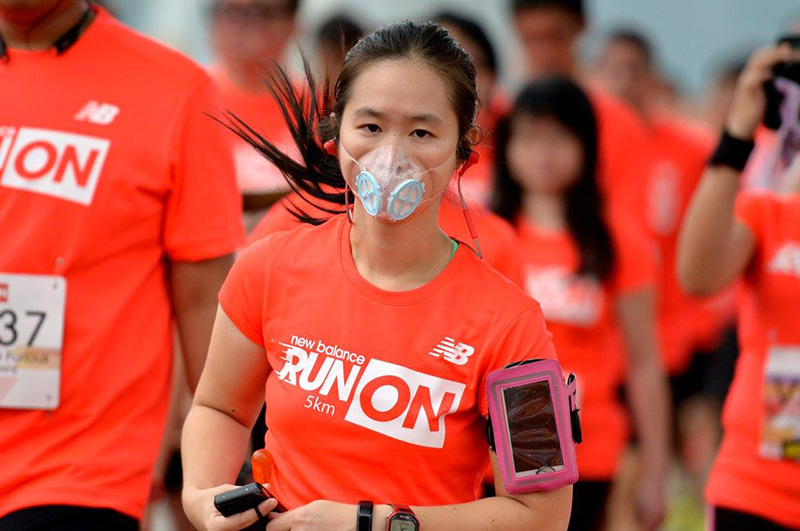

In [14]:
Image.open(f'{path}{train["image"][1]}')

In [15]:
train_images = []
train_labels = []

for i in range(len(train['target'])):
    if train['target'][i] == 0:
        train_images.append(f'{path}{train["image"][i]}')
        train_labels.append(train['target'][i])
    else:
        train_images.append(f'{path}{train["image"][i]}')
        train_labels.append(train['target'][i])

In [16]:
len(train['target'])

1306

In [17]:
train_images[0]

'C:/Users/SHOCKER/Downloads/Compressed/images_2/images/tfymlmdkpzkqdjhdxyhnoeuqszxphw.jpg'

In [18]:
train_images = np.array(train_images)
train_labels = np.array(train_labels)
test_images = np.array(test_images)

(-0.5, 159.5, 159.5, -0.5)

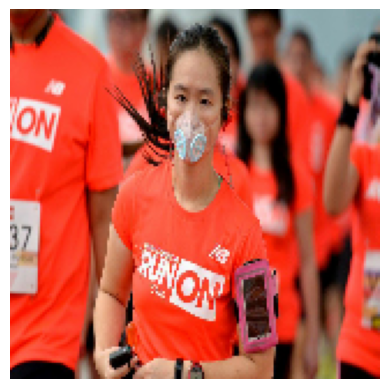

In [19]:
img = tf.io.read_file(train_images[1])
img = tf.io.decode_jpeg(img)
img = tf.image.resize(img, (160, 160))
img = tf.reshape(img, (160, 160, 3))
img = img / 255

plt.imshow(img)
plt.axis('off')

In [20]:
train_images = tf.data.Dataset.from_tensor_slices(train_images)
train_labels = tf.data.Dataset.from_tensor_slices(train_labels)
test_images = tf.data.Dataset.from_tensor_slices(test_images)

In [21]:
train_dataset = tf.data.Dataset.zip((train_images, train_labels))

In [22]:
train_dataset

<ZipDataset element_spec=(TensorSpec(shape=(), dtype=tf.string, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))>

In [23]:
def load_and_warp(image):
    img = tf.io.read_file(image)
    img = tf.io.decode_jpeg(img)
    img = tf.image.resize(img, (224, 224))
    img = tf.reshape(img, (224, 224, 3))
    img = img / 255

    return img

train_ds = train_dataset.map(lambda x, y: (load_and_warp(x), y))
test_ds = test_images.map(load_and_warp)

Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089


In [24]:
test_ds = test_ds.batch(32)

In [25]:
val_ds = train_ds.take(100)
train_ds2 = train_ds.skip(100)

In [26]:
val_ds = val_ds.batch(32)

In [27]:
train = train_ds.shuffle(1000).batch(32)

In [28]:
train

<BatchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>

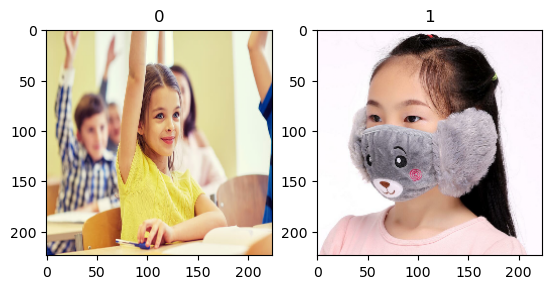

In [29]:
for image, label in train.take(1):
    for i in range(2):
        plt.subplot(1, 2, i+1)
        plt.imshow(image[i])
        plt.title(label[i].numpy())

In [30]:
augment = tf.keras.Sequential([
    tf.keras.Input(shape=(224, 224, 3)),
    tf.keras.layers.RandomRotation(40),
    tf.keras.layers.RandomZoom(0.2, 0.2),
    tf.keras.layers.RandomFlip('horizontal')
])

In [31]:
def prepare(ds, training=True):
    if training:
        ds = ds.map(lambda x, y: (augment(x), y), num_parallel_calls=tf.data.AUTOTUNE)
    return ds.prefetch(buffer_size=tf.data.AUTOTUNE)

In [32]:
train_ds_prepared = prepare(train)

In [33]:
train_ds_prepared

<PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>

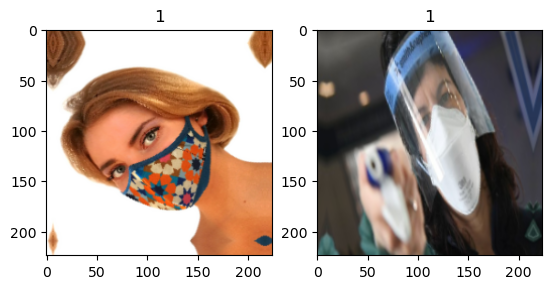

In [34]:
for image, label in train_ds_prepared.take(1):
    for i in range(2):
        plt.subplot(1, 2, i+1)
        plt.imshow(image[i])
        plt.title(label[i].numpy())

In [35]:
base_model = keras.applications.MobileNetV2(include_top=False, weights='imagenet')

In [36]:
for image, label in train_ds_prepared.take(1):
    feature_batch = base_model(image)
    feat = keras.layers.GlobalAveragePooling2D()(feature_batch)
    print(feat.shape)

(32, 1280)


In [40]:
base_model.trainable=False

In [41]:
inputs = tf.keras.Input(shape=(224, 224, 3))
x = base_model(inputs, training=False)
x = keras.layers.GlobalAveragePooling2D()(x)
x = tf.keras.layers.Dropout(0.2)(x)
x = tf.keras.layers.Dense(64, activation='relu')(x)
x = tf.keras.layers.Dense(1, activation='sigmoid')(x)
model = tf.keras.Model(inputs=inputs, outputs=x)

In [42]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 mobilenetv2_1.00_224 (Funct  (None, None, None, 1280)  2257984  
 ional)                                                          
                                                                 
 global_average_pooling2d_1   (None, 1280)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dropout (Dropout)           (None, 1280)              0         
                                                                 
 dense (Dense)               (None, 64)                81984     
                                                                 
 dense_1 (Dense)             (None, 1)                 65    

In [44]:
model.compile(loss = tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001),
              metrics = [tf.keras.metrics.BinaryAccuracy()])

In [45]:
history = model.fit(train_ds_prepared, epochs=10, validation_data=val_ds)

Epoch 1/10


/usr/local/lib/python3.8/dist-packages/tensorflow/python/util/dispatch.py:1082: UserWarning: "`binary_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  return dispatch_target(*args, **kwargs)


41/41 [==============================] - 20s 297ms/step - loss: 0.7246 - binary_accuracy: 0.5536 - val_loss: 0.4960 - val_binary_accuracy: 0.8300
Epoch 2/10
41/41 [==============================] - 15s 263ms/step - loss: 0.5851 - binary_accuracy: 0.6922 - val_loss: 0.3757 - val_binary_accuracy: 0.9300
Epoch 3/10
41/41 [==============================] - 15s 267ms/step - loss: 0.5392 - binary_accuracy: 0.7282 - val_loss: 0.3074 - val_binary_accuracy: 0.9500
Epoch 4/10
41/41 [==============================] - 15s 267ms/step - loss: 0.4862 - binary_accuracy: 0.7665 - val_loss: 0.2701 - val_binary_accuracy: 0.9400
Epoch 5/10
41/41 [==============================] - 16s 273ms/step - loss: 0.4654 - binary_accuracy: 0.7848 - val_loss: 0.2447 - val_binary_accuracy: 0.9400
Epoch 6/10
41/41 [==============================] - 16s 298ms/step - loss: 0.4311 - binary_accuracy: 0.8017 - val_loss: 0.2197 - val_binary_accuracy: 0.9400
Epoch 7/10
41/41 [==============================] - 15s 268ms/step - 

In [51]:
img = keras.utils.load_img('/root/.keras/datasets/images/mlmokfqnunuozvcadhcaijoxpwmgad.jpg')
img = keras.utils.img_to_array(img)
img = tf.image.resize(img, (224, 224))
img = img / 255

img = np.expand_dims(img, axis=0)

predict= model.predict(img)

if predict < 0.5:
  print('0')

1/1 [==============================] - 0s 23ms/step
0


In [52]:
# saving the model
model.save('face_mask model')

In [4]:
model = keras.models.load_model('face_mask model')

# Making it predict in real time

In [38]:
cap = cv2.VideoCapture(0)

while cap.isOpened():
    ret, frame = cap.read()
    rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    img = tf.image.resize(rgb, (224, 224))
    img = tf.reshape(img, (224, 224, 3))
    img = img / 255
    img = np.array(np.expand_dims(img, 0), dtype=np.float32)

    prediction = model.predict(img)
    print(prediction)

    if prediction > 0.5:
        cv2.putText(frame, 'You\'re wearing a face mask', [20, 50], cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 255, 255), 2, cv2.LINE_AA)
    
    else:
        cv2.putText(frame, 'Nope, no face mask', [20, 50], cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 255, 255), 2, cv2.LINE_AA)

    cv2.imshow('Mask Detection', frame)
    
    if cv2.waitKey(25) & 0xFF == ord('q'):
        break

cap.release()
cv2.destroyAllWindows()

1/1 [==============================] - 2s 2s/step
[[0.6804078]]
1/1 [==============================] - 0s 111ms/step
[[0.8495789]]
1/1 [==============================] - 0s 110ms/step
[[0.8523586]]
1/1 [==============================] - 0s 108ms/step
[[0.89199525]]
1/1 [==============================] - 0s 108ms/step
[[0.8815729]]
1/1 [==============================] - 0s 162ms/step
[[0.89643735]]
1/1 [==============================] - 0s 106ms/step
[[0.8735219]]
1/1 [==============================] - 0s 104ms/step
[[0.867824]]
1/1 [==============================] - 0s 101ms/step
[[0.9031829]]
1/1 [==============================] - 0s 105ms/step
[[0.8491718]]
1/1 [==============================] - 0s 102ms/step
[[0.81305856]]
1/1 [==============================] - 0s 109ms/step
[[0.85094804]]
1/1 [==============================] - 0s 118ms/step
[[0.85306305]]
1/1 [==============================] - 0s 106ms/step
[[0.802315]]
1/1 [==============================] - 0s 112ms/step
[[0.84139

Testing the model on some images

1/1 [==============================] - ETA: 0s

C:\Users\SHOCKER\anaconda\envs\tf_gpu\lib\site-packages\matplotlib\text.py:1165: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if s != self._text:


1/1 [==============================] - 0s 111ms/step


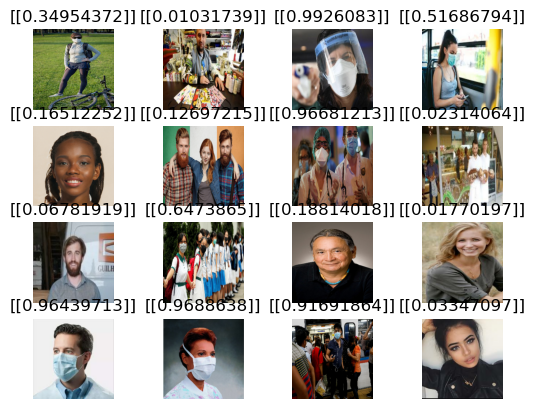

In [39]:
for img in test_ds.take(1):
    for i in range(16):
        plt.subplot(4, 4, i+1)
        plt.imshow(img[i])
        plt.axis('off')
        plt.title(model.predict(np.expand_dims(img[i], 0)))

In [3]:
# another test
rand_test = r'C:\Users\SHOCKER\Downloads\mask test.jpg'

In [5]:
img = keras.utils.load_img(rand_test)
img = keras.utils.img_to_array(img)
img = tf.image.resize(img, (224, 224))
img = img / 255

model.predict(tf.expand_dims(img, 0))

1/1 [==============================] - 4s 4s/step


array([[0.9647024]], dtype=float32)